In [102]:
import numpy as np
from IPython.display import Audio
import IPython.display as ipd
import matplotlib.pyplot as plt

from scipy import signal
import librosa

import scipy.fft

import scipy.io.wavfile as wavfile
import soundfile as sf 

import numpy as np

# Загрузка аудиофайла
fs, y = scipy.io.wavfile.read('test_mono.wav')
y = np.float32(y) / np.iinfo(y.dtype).max

In [211]:
Audio(y, rate = fs)

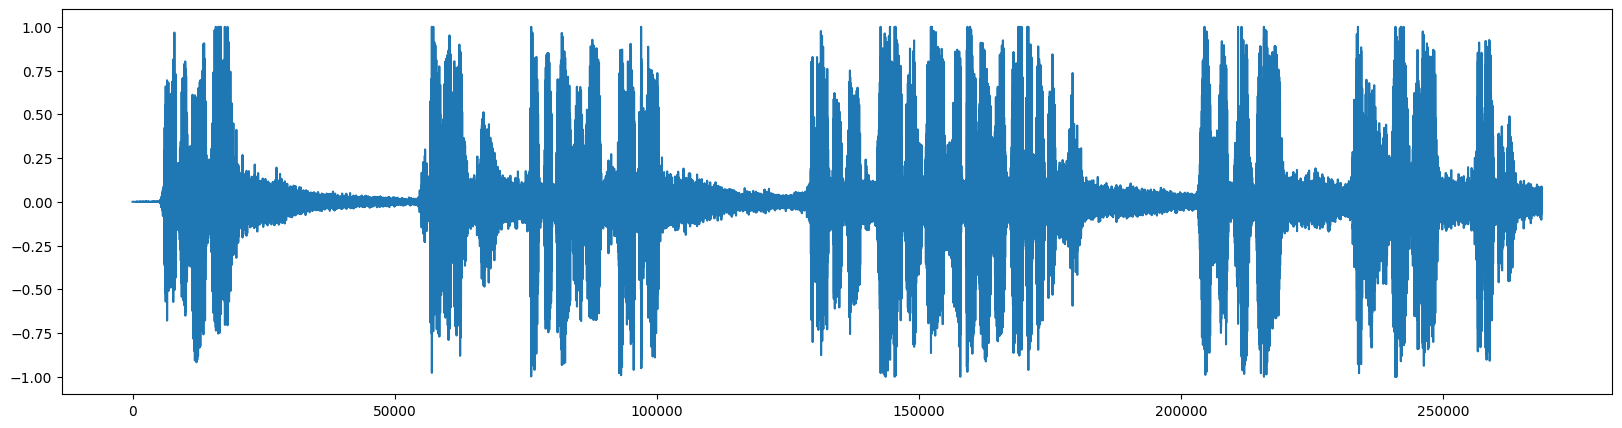

In [101]:
plt.figure(figsize=(20,5))
plt.plot(y)
#plt.plot(y_stretch)
plt.show()

Для растяжения или сжатия по длительности аудиодорожки с сохранением тональности с помощью Фазового вокодера необходимо выполнить следующие шаги:

- Загрузить аудиофайл с помощью библиотеки scipy.io.wavfile. При этом получите массив данных и частоту дискретизации.

- Разбейть сигнал на кадры с фиксированной длиной (например, 2048 отсчетов) и с перекрытием между ними (например, 50% от длины кадра).

- Для каждого кадра применить оконную функцию (например, Ханнинга).

- Для каждого кадра выполнить БПФ и получите спектр сигнала.

- Разделить спектр на модуль и фазу.

- Изменить длину каждого кадра, соответственно изменению длительности аудиодорожки. Для этого умножить модуль спектра на коэффициент масштабирования, который можно вычислить как отношение новой длины к текущей длине кадра.

- Произвести интерполяцию фазы на новую длину кадра при помощи линейной интерполяции.

- Получить новый спектр умножв измененный модуль на новую интерполированную фазу.

- Для каждого кадра выполнить ОБПФ синтезированного спектра и получить временной сигнал.

- Объединить временные сигналы с перекрытием и получить новый аудиофайл.

In [62]:
def time_stretch(filename, stretch_factor):
    # Чтение wav-файла
    sr, audio = wavfile.read(filename)
    #audio, sr = sf.read(filename)
    # Параметры фазового вокодера
    frame_size = 2048 #* 2
    hop_length = frame_size // 4
    fft_size = frame_size

    # Анализ сигнала
    audio_frames = np.array([audio[i:i+frame_size] for i in range(0, len(audio)-frame_size, hop_length)])
    window = np.hanning(frame_size)
    audio_frames = window * audio_frames
    audio_spec = np.fft.rfft(audio_frames, fft_size, axis=1)
    audio_mag = np.abs(audio_spec)
    audio_phase = np.angle(audio_spec)

    # Изменение продолжительности
    new_size = int(round(len(audio_frames) * stretch_factor))
    new_frames = np.zeros((new_size, frame_size), dtype=np.float32)
    phase_advances = np.linspace(0, np.pi * hop_length, frame_size // 2 + 1)

    for i in range(new_size):
        t = float(i) / stretch_factor
        i0 = int(t)
        i1 = i0 + 1
        alpha = t - i0
        if i1 >= len(audio_frames):
            break
        mag = audio_mag[i0, :] * (1 - alpha) + audio_mag[i1, :] * alpha
        phase = audio_phase[i1, :] + alpha * (audio_phase[i0, :] - audio_phase[i1, :])
        phase_advance = phase_advances * stretch_factor
        phase = phase + phase_advance
        frame = mag * np.exp(1.0j * phase)
        frame_ifft = np.fft.irfft(frame, frame_size)
        new_frames[i, :] = frame_ifft * window

    # Синтез нового аудиофайла
    new_audio = np.zeros((new_size-1) * hop_length + frame_size, dtype=np.float32)
    for i in range(new_size):
        start = i * hop_length
        end = start + frame_size
        new_audio[start:end] += new_frames[i]
    return new_audio

In [103]:
t_new = time_stretch(filename='test_mono.wav',stretch_factor= 0.5)

In [104]:
Audio(t_new, rate = fs)

Сравним полученную аудиодорожку с реализацией сжатия речи в библиотеке librosa.

In [94]:
y_stretch = librosa.effects.time_stretch(y=y, rate=2)

In [95]:
Audio(y_stretch, rate = fs)

Дорожки идентичны.